In [1]:
## Lib's needed
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from __future__ import print_function
# Import for spliting the data set
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
# Imports for classificaiton 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline
from sklearn import metrics as mt

# Set the figure sizes for the project 
rcParams['figure.figsize'] = 10, 10
# Import my custom lib 
# from StatsHelper import stats, plots, data_transformations

## Bring in data and perform some EDA

In [2]:
def corr_matrix(df):
    '''Generates Correlation Matrix'''
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = (15, 10))
    colormap = sns.diverging_palette(240, 10, n = 9, as_cmap = True)
    sns.heatmap(corr, mask = mask, cmap = colormap, center = 0,
                square = True, linewidths = .5, cbar_kws = {"shrink": 1})
    
# Bring in data
def create_data(filename):
    ''' 
    Bring in raw data file 
    Returns a dataframe
    '''
    df = pd.read_csv(filename)
    # Print the shape of the data
    shape = df.shape
    print("There are", shape[0], "rows and", shape[1],"columns")
    print("------------------------------------------------------")
    # Get the first 5 rows 
    print(df.head())
    print("------------------------------------------------------")
    # Get the variable informaton in the data
    print(df.info())
    # Fill in the NaN's in the data
    df = df.fillna(0)

    return df

In [3]:
filename = "FinalOverObTableWAR.csv"
raw_trees = create_data(filename)

There are 16575 rows and 66 columns
------------------------------------------------------
   CLUSTER     ID  tree_obs_id tree_spp  tree_dbh  tree_stems  tree_height  \
0      316  11638            5     PIRI        20           1           65   
1      316  11639            6     PIRI        10           1           55   
2      316  11640            7     PIRI        11           1           50   
3       52     40            2     PIRI         8           1           40   
4       53     41           11    CHTH2        13           1           65   

   source_tree_height tree_crown_class  source_tree_crown_class  ...  \
0                   6       codominant                        6  ...   
1                   6         dominant                        6  ...   
2                   6       codominant                        6  ...   
3                   6     intermediate                        6  ...   
4                   6       codominant                        6  ...   

   inve

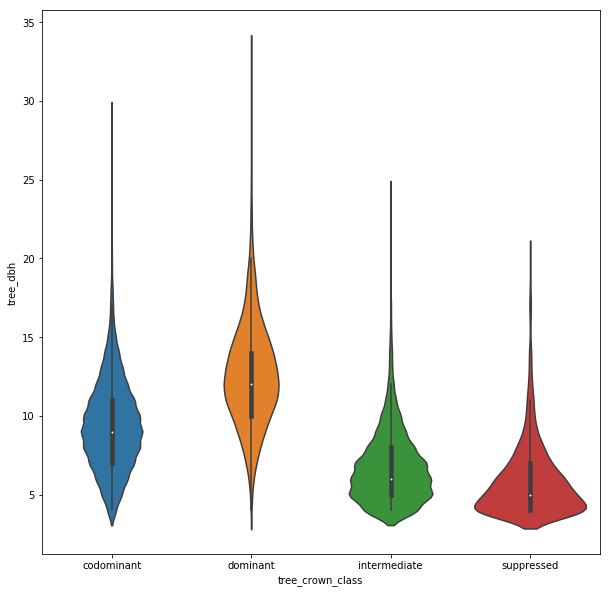

In [61]:
# Tree DBH vs Tree Crown Class
sns.violinplot(x = 'tree_crown_class', y = 'tree_dbh', data = raw_trees)

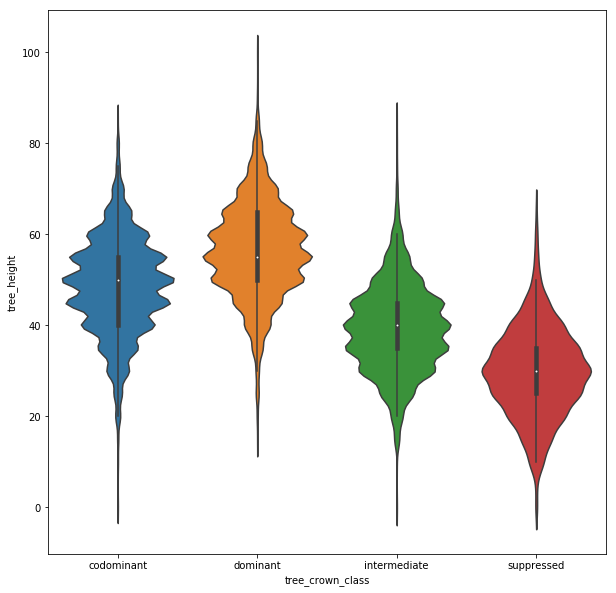

In [58]:
# Tree Height vs Tree Crown Class
sns.violinplot(x = 'tree_crown_class', y = 'tree_height', data = raw_trees)

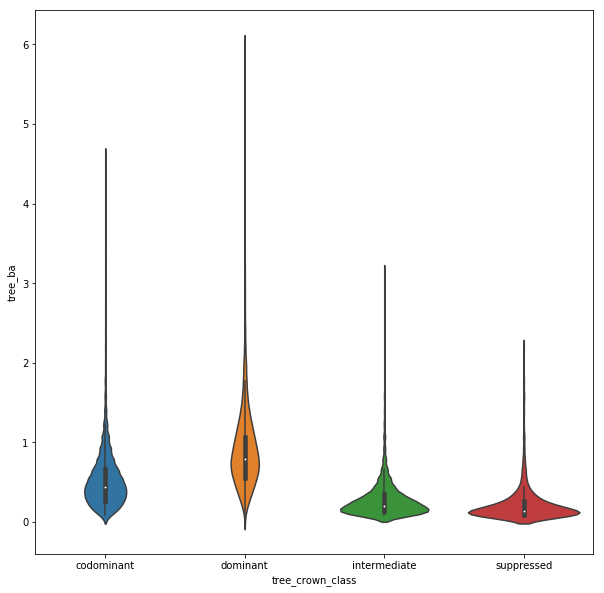

In [57]:
# Tree Crown Condtion vs Tree Crown Class
sns.violinplot(x = 'tree_crown_class', y = 'tree_ba', data = raw_trees)

In [78]:
# Get the distribution of each crown class
dominate = raw_trees.loc[raw_trees['tree_crown_class'] == 'dominant']
codominate = raw_trees.loc[raw_trees['tree_crown_class'] == 'codominant']
intermediant = raw_trees.loc[raw_trees['tree_crown_class'] == 'intermediate']
suppressed = raw_trees.loc[raw_trees['tree_crown_class'] == 'suppressed']

Text(0,0.5,'DBH')

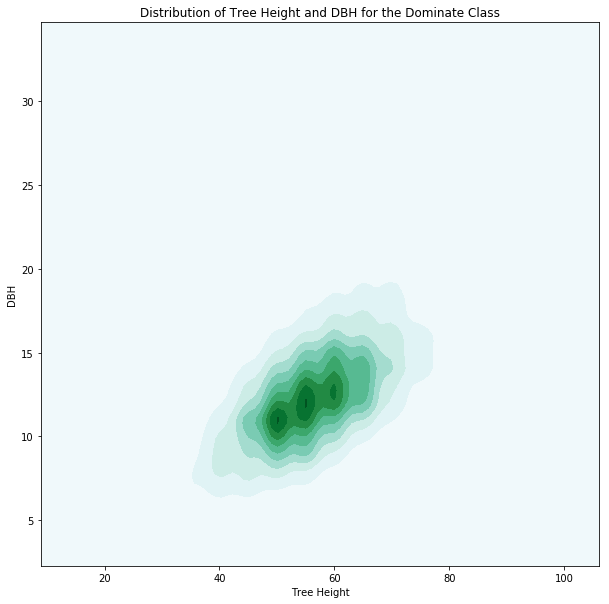

In [85]:
sns.kdeplot(dominate['tree_height'], dominate['tree_dbh'], shade=True)
title = "Distribution of Tree Height and DBH for the Dominate Class"
xlabel = "Tree Height"
ylabel = "DBH"
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

Text(0,0.5,'DBH')

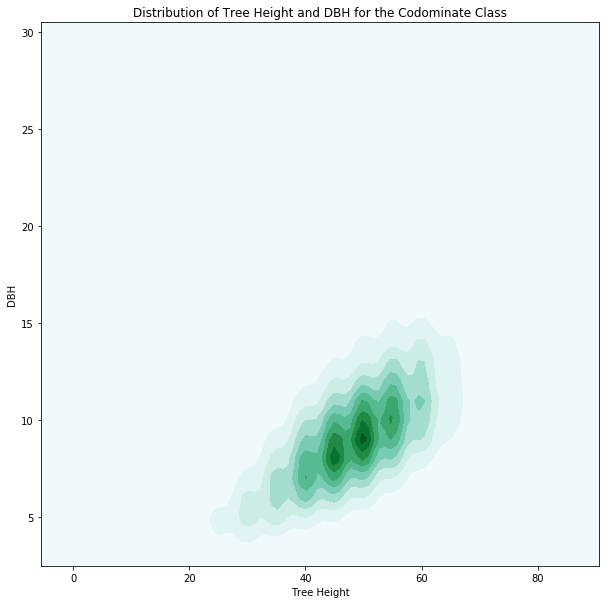

In [86]:
sns.kdeplot(codominate['tree_height'], codominate['tree_dbh'], shade=True)
title = "Distribution of Tree Height and DBH for the Codominate Class"
xlabel = "Tree Height"
ylabel = "DBH"
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

Text(0,0.5,'DBH')

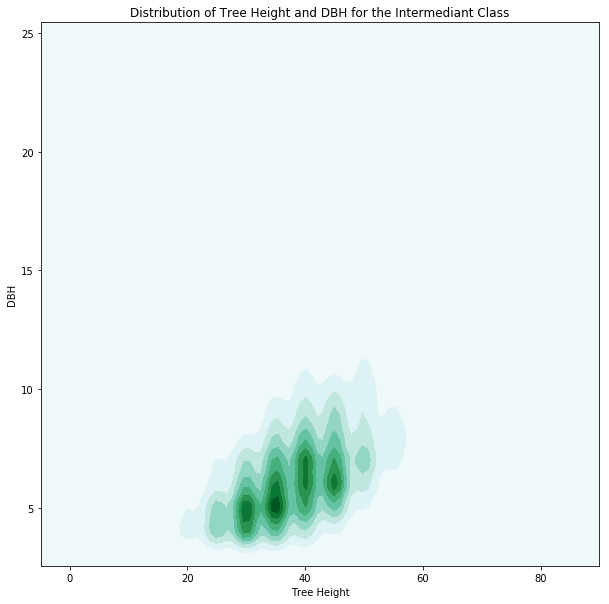

In [87]:
sns.kdeplot(intermediant['tree_height'], intermediant['tree_dbh'], shade=True)
title = "Distribution of Tree Height and DBH for the Intermediant Class"
xlabel = "Tree Height"
ylabel = "DBH"
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

Text(0,0.5,'DBH')

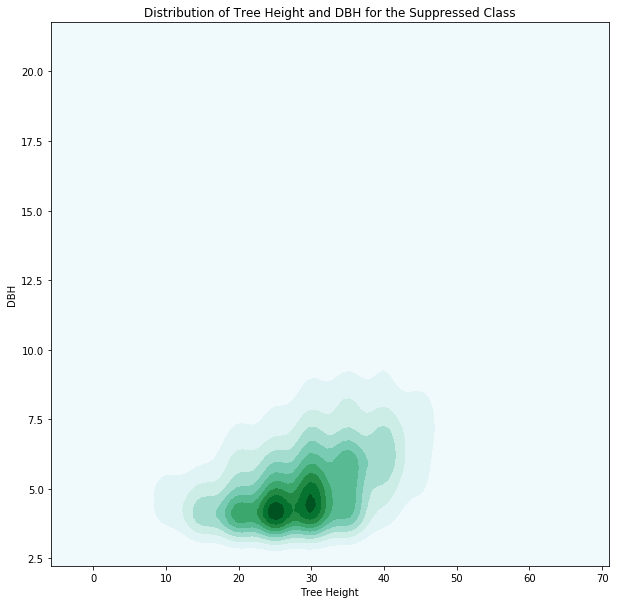

In [88]:
sns.kdeplot(suppressed['tree_height'], suppressed['tree_dbh'], shade=True)
title = "Distribution of Tree Height and DBH for the Suppressed Class"
xlabel = "Tree Height"
ylabel = "DBH"
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)

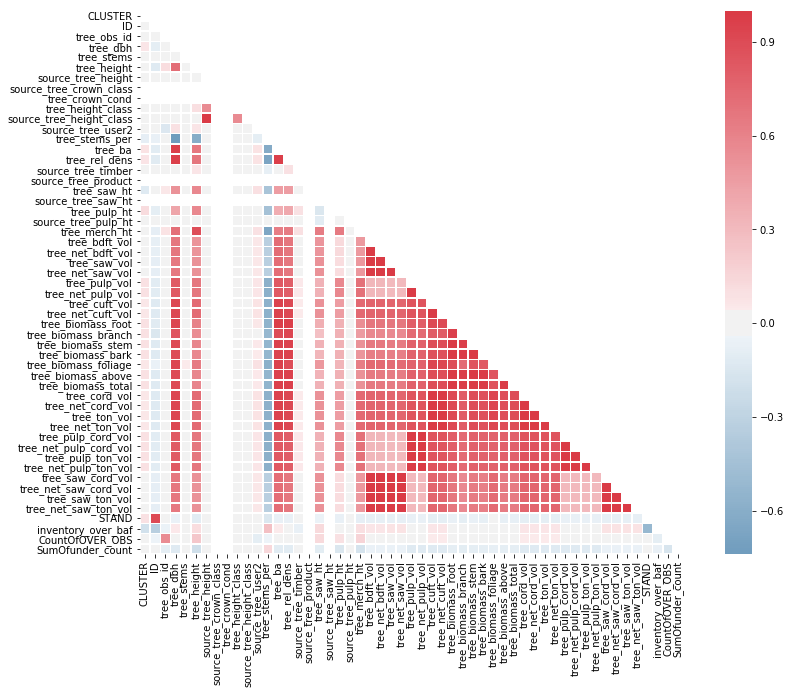

In [91]:
corr_matrix(raw_trees)

## Splitting the data into training and testing sets

The goal of performing cross-validation is to split our data into a training set and test set. The training set is split up into multiple validation sets. We are going to use stratified K-fold cross-validation with 10 splits (K=10) for our classification tasks. This is because our data is unbalanced. There is a total of 17,426 observations in our data set. Out of all the observations, 8,022 observations are made up of co-dominate trees (about half). Stratified K-fold cross-validation ensures that each of our training sets contains an equal proportion of each unbalanced variable.

In [4]:
raw_trees.head()

,CLUSTER,ID,tree_obs_id,tree_spp,tree_dbh,tree_stems,tree_height,source_tree_height,tree_crown_class,source_tree_crown_class,...,inventory_over_baf,GrndQUIL,GrndSMILA2,CRUISER,MUSYM,Wetland,CountOfOVER_OBS,OverObs_CountCheck_over_id,under_id,SumOfunder_count
0,316,11638,5,PIRI,20,1,65,6,codominant,6,...,10,N,Y,AMB,LakB,N,14,POKWAR047,POKWAR047,1.0
1,316,11639,6,PIRI,10,1,55,6,dominant,6,...,10,N,Y,AMB,LakB,N,14,POKWAR047,POKWAR047,1.0
2,316,11640,7,PIRI,11,1,50,6,codominant,6,...,10,N,Y,AMB,LakB,N,14,POKWAR047,POKWAR047,1.0
3,52,40,2,PIRI,8,1,40,6,intermediate,6,...,30,N,N,SGH,FmgAt,Y,10,cswwar006,cswwar006,18.0
4,53,41,11,CHTH2,13,1,65,6,codominant,6,...,30,N,Y,SGH,FmgAt,Y,12,cswwar007,cswwar007,2.0


In [5]:
# Split the data into traning (80%) and test set (20%)
# We are using stratified cross validation here because the majority of the
#    individuals in the variable we want to classify are codominant
tree_data = raw_trees
if 'tree_crown_class' in tree_data:
    y = tree_data['tree_crown_class'].values # get values we need 
    del tree_data['tree_crown_class']        # get rid of the class label
    X = tree_data.values                     # use everything else to classify 

X = pd.get_dummies(tree_data).values

# Scale attributes by the training set
scl = StandardScaler()
X = scl.fit_transform(X)

# Split the data into 20% Test and 80% Train using StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.20, random_state=111)
sss.get_n_splits(X, y) #retreving the splits

10

In [89]:
print("These are the Stratified Shuffle Split parameters:")
print("---------------------------------------------------")
print(sss)

These are the Stratified Shuffle Split parameters:
---------------------------------------------------
StratifiedShuffleSplit(n_splits=10, random_state=111, test_size=0.2,
            train_size=None)


In [6]:
# Create a for loop that grabs the values for each fold for traing and test sets
for train_index, test_index in sss.split(X, y):
    # Let's print them out just for a sanity check
    print("TRAIN:", train_index, "TEST:", test_index)
    # Create the X train/test and y train/test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 7968 13010  3166 ...  9730  3442  2376] TEST: [12695  9400 10896 ...  2347 12289  5015]
TRAIN: [ 9027  4914 11653 ... 15659 13836  2036] TEST: [16523  1882  6998 ...  6901 16026  2639]
TRAIN: [ 3626 12012   780 ...  4275  8684  2544] TEST: [12136  2691 11371 ...  5807  1501  1732]
TRAIN: [ 1287 15736  1888 ...  2566  6329 12105] TEST: [ 4374  1246  5762 ...  7367  9537 16372]
TRAIN: [ 1587  7874  9155 ...  1767 15841 11276] TEST: [10663  5453 12831 ... 11178 13312 10650]
TRAIN: [ 3137  7585  6743 ... 15753  2748  2011] TEST: [ 3617  3088  1009 ... 15413 10928  1974]
TRAIN: [16423 15760  8915 ...  7807 11684 11747] TEST: [10910  3387 10672 ...  6605  5262  1597]
TRAIN: [ 9600 11615  7841 ...  2207 14674 12395] TEST: [15750  3722 15351 ...  5257 12194  8521]
TRAIN: [11231 11128  3426 ...  8630  3575 10873] TEST: [ 1429  8383 10026 ... 13137  4626 12952]
TRAIN: [14871  1705  7857 ...  6898  2083  2489] TEST: [ 2951  4978   452 ... 14491  5837  7684]


## Let's Classify
Now thaat we have our training and testing sets, we will use a few different classification mehtods. At the end of this section we will assess the precision, recall, f1-score, and support to find the best classification method. We will use PCA to evaluate feature importance and select the most relevant features.

### KNN
Classifier implementing the k-nearest neighbors vote

In [20]:
# In this snippet we make use of a PCA to evaluate feature importances and 
# select the most relevant features. Then, a KNeighborsClassifier is trained on the transformed output, 
# i.e. using only relevant features. 

# n_neighbors <- Number of neighbors to use
# p <- Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), 
#      and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used
# algorithm <- Algorithm used to compute the nearest neighbors

# First we need to set up the PipeLine that will take the PCA and then fit a KNN classifier
KNN_pipe = Pipeline([('PCA', PCA(n_components = 5, svd_solver = 'randomized')),
                     ('KNN', KNeighborsClassifier(n_neighbors = 50,
                                                  p = 2,
                                                  algorithm = 'kd_tree'))
                    ])

# Next we need to iterate through and get the prediction, like we did above
iter_num = 0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X, y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    KNN_pipe.fit(X_train, y_train)    # train object
    y_hat = KNN_pipe.predict(X_test) # get test set precitions
    
    # accuracy for the iterations of training/testing
    accuracy_KNN_pipe = mt.accuracy_score(y_test, y_hat)  # obtain accuracies for each iteration 
    print("---- Iteration", iter_num, " ----")              # print out each numbered iteration 
    print('KNN PipeLine accuracy =', accuracy_KNN_pipe)
    print("__________________________________________________")
    
    #Metric report 
    metrics_KNN_pipe = classification_report(y_test,y_hat)  # obtain metric's report for each iteration 
    print('KNN & PCA metric report')
    print(metrics_KNN_pipe)
    
    iter_num += 1  # run through the first iteration, then second, then third ... then tenth

---- Iteration 0  ----
KNN PipeLine accuracy = 0.6132730015082957
__________________________________________________
KNN & PCA metric report
              precision    recall  f1-score   support

  codominant       0.61      0.78      0.69      1604
    dominant       0.68      0.59      0.63       969
intermediate       0.49      0.32      0.38       539
  suppressed       0.51      0.18      0.27       203

 avg / total       0.60      0.61      0.60      3315

---- Iteration 1  ----
KNN PipeLine accuracy = 0.6111613876319759
__________________________________________________
KNN & PCA metric report
              precision    recall  f1-score   support

  codominant       0.60      0.79      0.68      1604
    dominant       0.68      0.57      0.62       969
intermediate       0.51      0.30      0.38       539
  suppressed       0.56      0.20      0.30       203

 avg / total       0.61      0.61      0.59      3315

---- Iteration 2  ----
KNN PipeLine accuracy = 0.604524886877828

In [32]:
KNN_precision = [0.59, 0.59, 0.60, 0.59, 0.60, 0.61, 0.60, 0.60, 0.61, 0.60]
KNN_recall = [0.59, 0.60, 0.60, 0.60, 0.61, 0.61, 0.61, 0.60, 0.61, 0.61]
KNN_f1 = [0.57, 0.58, 0.58, 0.58, 0.59, 0.59, 0.58, 0.59, 0.59, 0.60]

mean_KNN_precision = np.mean(KNN_precision).round(2)
print("The mean precision for this model is ", mean_KNN_precision)
mean_KNN_recall = np.mean(KNN_recall).round(2)
print("The mean recall for this model is ", mean_KNN_recall)
mean_KNN_f1 = np.mean(KNN_f1).round(2)
print("The mean f1-score for this model is ", mean_KNN_f1)

The mean precision for this model is  0.6
The mean recall for this model is  0.6
The mean f1-score for this model is  0.58


In [41]:
# Get the mean accuracy
# Load the accuracies
accuracies_KNN = cross_val_score(KNN_pipe, X, y = y, cv = sss) # this also can help with parallelism
# Print out the mean 
mean_KNN = np.mean(accuracies_KNN).round(2)
print("The mean accuracy for this model is ", mean_KNN)

The mean accuracy for this model is  0.61


### Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [18]:
# In this snippet we make use of a PCA to evaluate feature importances and 
# select the most relevant features. Then, a RandomForestClassifier is trained on the transformed output, 
# i.e. using only relevant features. 

# n_estimators <- The number of trees in the forest
# criterion <- The function to measure the quality of a split. Supported criteria are “gini” for 
#              the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific
# max_depth <- The maximum depth of the tree. If None, then nodes are expanded until all 
#              leaves are pure or until all leaves contain less than min_samples_split samples
# min_samples_split <- The minimum number of samples required to split an internal node (default = 2)
# max_features <- The number of features to consider when looking for the best split

# First we need to set up the PipeLine that will take the PCA and then fit a RF classifier
RF_pipe = Pipeline([('PCA', PCA(n_components = 5, svd_solver = 'randomized')),
                    ('classification', RandomForestClassifier(n_estimators = 300,
#                                                               max_depth = 10,
                                                              max_features = 'log2',
                                                              min_samples_split = 2,
                                                              criterion = 'entropy',
                                                              random_state = 111))
                    ])

# Next we need to iterate through and get the prediction, like we did above
iter_num = 0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X, y): 
    X_train = X[train_indices]  # train indices for X
    y_train = y[train_indices]  # train indices for y
    
    X_test = X[test_indices]    # test indices for X
    y_test = y[test_indices]    # test indices for y
    
    # train the reusable KNN classifier on the training data
    RF_pipe.fit(X_train, y_train)    # train object
    y_hat = RF_pipe.predict(X_test) # get test set precitions
    
    # accuracy for the iterations of training/testing
    accuracy_RF_pipe = mt.accuracy_score(y_test, y_hat)  # obtain accuracies for each iteration 
    print("---- Iteration", iter_num, " ----")              # print out each numbered iteration 
    print('RF PipeLine accuracy =', accuracy_RF_pipe)
    print("__________________________________________________")
    
    #Metric report 
    metrics_RF_pipe = classification_report(y_test, y_hat)  # obtain metric's report for each iteration 
    print('RF & PCA metric report')
    print(metrics_RF_pipe)
    
    iter_num += 1  # run through the first iteration, then second, then third ... then tenth

---- Iteration 0  ----
RF PipeLine accuracy = 0.6470588235294118
__________________________________________________
RF & PCA metric report
              precision    recall  f1-score   support

  codominant       0.65      0.77      0.71      1604
    dominant       0.68      0.62      0.65       969
intermediate       0.57      0.42      0.48       539
  suppressed       0.60      0.38      0.47       203

 avg / total       0.64      0.65      0.64      3315

---- Iteration 1  ----
RF PipeLine accuracy = 0.6476621417797889
__________________________________________________
RF & PCA metric report
              precision    recall  f1-score   support

  codominant       0.65      0.78      0.71      1604
    dominant       0.69      0.62      0.65       969
intermediate       0.58      0.44      0.50       539
  suppressed       0.56      0.32      0.40       203

 avg / total       0.64      0.65      0.64      3315

---- Iteration 2  ----
RF PipeLine accuracy = 0.6410256410256411
___

In [31]:
RF_precision = [0.63, 0.64, 0.63, 0.63, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64]
RF_recall = [0.63, 0.64, 0.63, 0.64, 0.64, 0.64, 0.64, 0.64, 0.65, 0.65]
RF_f1 = [0.62, 0.63, 0.62, 0.63, 0.63, 0.64, 0.63, 0.63, 0.64, 0.64]

mean_RF_precision = np.mean(RF_precision).round(2)
print("The mean precision for this model is ", mean_RF_precision)
mean_RF_recall = np.mean(RF_recall).round(2)
print("The mean recall for this model is ", mean_RF_recall)
mean_RF_f1 = np.mean(RF_f1).round(2)
print("The mean f1-score for this model is ", mean_RF_f1)

The mean precision for this model is  0.64
The mean recall for this model is  0.64
The mean f1-score for this model is  0.63


In [40]:
# Get the mean accuracy
# Load the accuracies
accuracies_RF = cross_val_score(RF_pipe, X, y = y, cv = sss) # this also can help with parallelism
# Print out the mean 
mean_RF = np.mean(accuracies_RF).round(2)
print("The mean accuracy for this model is ", mean_RF)

The mean accuracy for this model is  0.64


### SVM
C-Support Vector Classification

In [14]:
# In this snippet we make use of a PCA to evaluate feature importances and 
# select the most relevant features. Then, a SVM is trained on the transformed output, 
# i.e. using only relevant features. 

# kernel <- Specifies the kernel type to be used in the algorithm
#            linear’, ‘poly’, ‘rbf’, ‘sigmoid

# Linear = 56.49
# RBF = 62.07
# sigmoid = 41.11
# poly = Took way too long to train, had it running for abour 2 hour before I shut it down 
#        and since I dont thing the polynomial is the way to go then we wont train it again and will stick 
#        with the rbf kernel

# First we need to set up the PipeLine that will take the PCA and then fit a GNB classifier
SVC_pipe = Pipeline([('PCA', PCA(n_components = 5, svd_solver = 'randomized')),
                     ('classification', SVC(kernel ='rbf',
                                            random_state = 111))
                    ])

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num = 0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X, y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    SVC_pipe.fit(X_train, y_train)  # train object
    y_hat = SVC_pipe.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_SVC_pipe = mt.accuracy_score(y_test, y_hat)
    print("---- Iteration", iter_num," ----")          # print out each numbered iteration 
    print('SVC accuracy =', accuracy_SVC_pipe)
    
    # Metric report 
    metrics_SVC_pipe = classification_report(y_test, y_hat)
    print('SVC metric report')
    print(metrics_SVC_pipe)

    iter_num += 1 # run through the first iteration, then second, then third ... then tenth

---- Iteration 0  ----
SVC accuracy = 0.6337858220211161
SVC metric report
              precision    recall  f1-score   support

  codominant       0.63      0.80      0.70      1604
    dominant       0.70      0.58      0.63       969
intermediate       0.54      0.35      0.43       539
  suppressed       0.62      0.30      0.40       203

 avg / total       0.63      0.63      0.62      3315

---- Iteration 1  ----
SVC accuracy = 0.6280542986425339
SVC metric report
              precision    recall  f1-score   support

  codominant       0.63      0.78      0.69      1604
    dominant       0.68      0.59      0.63       969
intermediate       0.53      0.41      0.46       539
  suppressed       0.57      0.23      0.33       203

 avg / total       0.62      0.63      0.62      3315

---- Iteration 2  ----
SVC accuracy = 0.6180995475113122
SVC metric report
              precision    recall  f1-score   support

  codominant       0.62      0.78      0.69      1604
    dominant

In [30]:
SVC_precision = [0.61, 0.61, 0.62, 0.63, 0.63, 0.62, 0.61, 0.62, 0.62,0.63]
SVC_recall = [0.61, 0.61, 0.62, 0.63, 0.63, 0.62, 0.61, 0.62, 0.63,0.63]
SVC_f1 = [0.59, 0.60, 0.60, 0.61, 0.62, 0.61, 0.60, 0.61, 0.62,0.62]

mean_SVC_precision = np.mean(SVC_precision).round(2)
print("The mean precision for this model is ", mean_SVC_precision)
mean_SVC_recall = np.mean(SVC_recall).round(2)
print("The mean recall for this model is ", mean_SVC_recall)
mean_SVC_f1 = np.mean(SVC_f1).round(2)
print("The mean f1-score for this model is ", mean_SVC_f1)

The mean precision for this model is  0.62
The mean recall for this model is  0.62
The mean f1-score for this model is  0.61


In [39]:
# Get the mean accuracy
# Load the accuracies
accuracies_SVC = cross_val_score(SVC_pipe, X, y = y, cv = sss) # this also can help with parallelism
# Print out the mean 
mean_SVC = np.mean(accuracies_SVC).round(2)
print("The mean accuracy for this model is ", mean_SVC)

The mean accuracy for this model is  0.62


### Gaussian Naive Bayes 

In [11]:
# In this snippet we make use of a PCA to evaluate feature importances and 
# select the most relevant features. Then, a GaussianNB is trained on the transformed output, 
# i.e. using only relevant features. 

# First we need to set up the PipeLine that will take the PCA and then fit a GNB classifier
GNB_pipe = Pipeline([('PCA', PCA(n_components = 7, svd_solver = 'randomized')),
                     ('classification', GaussianNB())
                    ])

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num = 0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X, y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    GNB_pipe.fit(X_train, y_train)  # train object
    y_hat = GNB_pipe.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_GNB_pipe = mt.accuracy_score(y_test, y_hat)
    print("---- Iteration",iter_num," ----")          # print out each numbered iteration 
    print('GNB accuracy =', accuracy_GNB_pipe)
    
    # Metric report 
    metrics_GNB_pipe = classification_report(y_test,y_hat)
    print('GNB metric report')
    print(metrics_GNB_pipe)

    iter_num += 1 # run through the first iteration, then second, then third ... then tenth

---- Iteration 0  ----
GNB accuracy = 0.5592760180995475
GNB metric report
              precision    recall  f1-score   support

  codominant       0.59      0.75      0.66      1604
    dominant       0.68      0.42      0.52       969
intermediate       0.37      0.40      0.39       539
  suppressed       0.36      0.15      0.21       203

 avg / total       0.56      0.56      0.54      3315

---- Iteration 1  ----
GNB accuracy = 0.5574660633484163
GNB metric report
              precision    recall  f1-score   support

  codominant       0.59      0.74      0.65      1604
    dominant       0.68      0.41      0.51       969
intermediate       0.38      0.42      0.40       539
  suppressed       0.37      0.17      0.23       203

 avg / total       0.57      0.56      0.54      3315

---- Iteration 2  ----
GNB accuracy = 0.5568627450980392
GNB metric report
              precision    recall  f1-score   support

  codominant       0.55      0.86      0.67      1604
    dominant

In [29]:
GNB_precision = [0.55, 0.57, 0.56, 0.57, 0.56, 0.56, 0.54, 0.56, 0.56, 0.57]
GNB_recall = [0.56, 0.57, 0.55, 0.56, 0.56, 0.56, 0.55, 0.56, 0.56, 0.56]
GNB_f1 = [0.53, 0.55, 0.54, 0.54, 0.52, 0.53, 0.49, 0.54, 0.54, 0.54]

mean_GNB_precision = np.mean(GNB_precision).round(2)
print("The mean precision for this model is ", mean_GNB_precision)
mean_GNB_recall = np.mean(GNB_recall).round(2)
print("The mean recall for this model is ", mean_GNB_recall)
mean_GNB_f1 = np.mean(GNB_f1).round(2)
print("The mean f1-score for this model is ", mean_GNB_f1)

The mean precision for this model is  0.56
The mean recall for this model is  0.56
The mean f1-score for this model is  0.53


In [38]:
# Get the mean accuracy
# Load the accuracies
accuracies_GNB = cross_val_score(GNB_pipe, X, y = y, cv = sss) # this also can help with parallelism
# Print out the mean 
mean_GNB = np.mean(accuracies_GNB).round(2)
print("The mean accuracy for this model is ", mean_GNB)

The mean accuracy for this model is  0.56


###  Bernoulli Naive Bayes 

In [7]:
# In this snippet we make use of a PCA to evaluate feature importances and 
# select the most relevant features. Then, a BernoulliNB is trained on the transformed output, 
# i.e. using only relevant features. 

# First we need to set up the PipeLine that will take the PCA and then fit a GNB classifier
BNB_pipe = Pipeline([('PCA', PCA(n_components = 7, svd_solver = 'randomized')),
                     ('classification', BernoulliNB())
                    ])

# Now we want to iterate through and grab the prediction, just like we did in the RF2 above
iter_num=0
# The indices are the rows used for training and testing in each iteration
for train_indices, test_indices in sss.split(X, y): 
    X_train = X[train_indices]  #train indices for X
    y_train = y[train_indices]  #train indices for y
    
    X_test = X[test_indices]    #test indices for X
    y_test = y[test_indices]    #test indices for y
    
    # Train the reusable KNN classifier on the training data
    BNB_pipe.fit(X_train, y_train)  # train object
    y_hat = BNB_pipe.predict(X_test) #get the test set predictions 
    
    # Accuracy for the iterations of training/testing
    accuracy_BNB_pipe= mt.accuracy_score(y_test, y_hat)
    print("---- Iteration", iter_num," ----")          # print out each numbered iteration 
    print('BNB accuracy =', accuracy_BNB_pipe)

    # Metric report 
    metrics_BNB_pipe = classification_report(y_test, y_hat)
    print('BNB metric report')
    print(metrics_BNB_pipe)
    
    iter_num+=1 # run through the first iteration, then second, then third ... then tenth

---- Iteration 0  ----
BNB accuracy = 0.5577677224736048
BNB metric report
              precision    recall  f1-score   support

  codominant       0.55      0.76      0.64      1604
    dominant       0.61      0.60      0.61       969
intermediate       0.32      0.08      0.13       539
  suppressed       0.00      0.00      0.00       203

 avg / total       0.50      0.56      0.51      3315



/Users/timmcwilliams/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---- Iteration 1  ----
BNB accuracy = 0.5517345399698341
BNB metric report
              precision    recall  f1-score   support

  codominant       0.55      0.72      0.62      1604
    dominant       0.60      0.62      0.61       969
intermediate       0.33      0.13      0.18       539
  suppressed       0.24      0.03      0.06       203

 avg / total       0.51      0.55      0.51      3315

---- Iteration 2  ----
BNB accuracy = 0.5384615384615384
BNB metric report
              precision    recall  f1-score   support

  codominant       0.55      0.72      0.62      1604
    dominant       0.58      0.57      0.57       969
intermediate       0.30      0.13      0.18       539
  suppressed       0.00      0.00      0.00       203

 avg / total       0.48      0.54      0.50      3315



/Users/timmcwilliams/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---- Iteration 3  ----
BNB accuracy = 0.551131221719457
BNB metric report
              precision    recall  f1-score   support

  codominant       0.55      0.76      0.64      1604
    dominant       0.61      0.54      0.57       969
intermediate       0.37      0.15      0.22       539
  suppressed       0.00      0.00      0.00       203

 avg / total       0.50      0.55      0.51      3315



/Users/timmcwilliams/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---- Iteration 4  ----
BNB accuracy = 0.5411764705882353
BNB metric report
              precision    recall  f1-score   support

  codominant       0.55      0.72      0.62      1604
    dominant       0.58      0.58      0.58       969
intermediate       0.33      0.14      0.20       539
  suppressed       0.00      0.00      0.00       203

 avg / total       0.49      0.54      0.50      3315



/Users/timmcwilliams/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---- Iteration 5  ----
BNB accuracy = 0.5514328808446456
BNB metric report
              precision    recall  f1-score   support

  codominant       0.54      0.75      0.63      1604
    dominant       0.60      0.60      0.60       969
intermediate       0.34      0.08      0.13       539
  suppressed       0.00      0.00      0.00       203

 avg / total       0.49      0.55      0.50      3315



/Users/timmcwilliams/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---- Iteration 6  ----
BNB accuracy = 0.5453996983408748
BNB metric report
              precision    recall  f1-score   support

  codominant       0.54      0.73      0.62      1604
    dominant       0.59      0.60      0.60       969
intermediate       0.32      0.09      0.14       539
  suppressed       0.28      0.05      0.08       203

 avg / total       0.51      0.55      0.50      3315

---- Iteration 7  ----
BNB accuracy = 0.5457013574660633
BNB metric report
              precision    recall  f1-score   support

  codominant       0.56      0.68      0.61      1604
    dominant       0.58      0.61      0.59       969
intermediate       0.36      0.25      0.29       539
  suppressed       0.00      0.00      0.00       203

 avg / total       0.50      0.55      0.52      3315



/Users/timmcwilliams/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---- Iteration 8  ----
BNB accuracy = 0.5408748114630467
BNB metric report
              precision    recall  f1-score   support

  codominant       0.54      0.75      0.63      1604
    dominant       0.58      0.56      0.57       969
intermediate       0.33      0.03      0.05       539
  suppressed       0.31      0.20      0.25       203

 avg / total       0.51      0.54      0.49      3315

---- Iteration 9  ----
BNB accuracy = 0.5339366515837104
BNB metric report
              precision    recall  f1-score   support

  codominant       0.53      0.75      0.62      1604
    dominant       0.57      0.54      0.55       969
intermediate       0.32      0.10      0.15       539
  suppressed       0.00      0.00      0.00       203

 avg / total       0.48      0.53      0.49      3315



/Users/timmcwilliams/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
BNB_precision = [0.48, 0.51, 0.50, 0.51, 0.49, 0.49, 0.50, 0.48, 0.51, 0.50]
BNB_recall = [0.53, 0.54, 0.55, 0.55, 0.55, 0.54, 0.55, 0.54, 0.55, 0.56]
BNB_f1 = [0.49, 0.49, 0.52, 0.50, 0.50, 0.50, 0.51, 0.50, 0.51, 0.51]

mean_BNB_precision = np.mean(BNB_precision).round(2)
print("The mean precision for this model is ", mean_BNB_precision)
mean_BNB_recall = np.mean(BNB_recall).round(2)
print("The mean recall for this model is ", mean_BNB_recall)
mean_BNB_f1 = np.mean(BNB_f1).round(2)
print("The mean f1-score for this model is ", mean_BNB_f1)

The mean precision for this model is  0.5
The mean recall for this model is  0.55
The mean f1-score for this model is  0.5


In [37]:
# Get the mean accuracy
# Load the accuracies
accuracies_BNB = cross_val_score(BNB_pipe, X, y = y, cv = sss) # this also can help with parallelism
# Print out the mean 
mean_BNB = np.mean(accuracies_BNB).round(2)
print("The mean accuracy for this model is ", mean_BNB)

The mean accuracy for this model is  0.55


## Model Comparison
Here we will compare how well the models performed

In [42]:
print("The mean accuracy for the KNN model is ", mean_KNN)
print(" ")
print("The mean accuracy for the Random Forest model is ", mean_RF)
print(" ")
print("The mean accuracy for the SVM model is ", mean_SVC)
print(" ")
print("The mean accuracy for the Gaussian NB model is ", mean_GNB)
print(" ")
print("The mean accuracy for the Bernoulli NB model is ", mean_BNB)

The mean accuracy for the KNN model is  0.61
 
The mean accuracy for the Random Forest model is  0.64
 
The mean accuracy for the SVM model is  0.62
 
The mean accuracy for the Gaussian NB model is  0.56
 
The mean accuracy for the Bernoulli NB model is  0.55


In [34]:
print("The mean precision for the KNN model is ", mean_KNN_precision)
print(" ")
print("The mean precision for the Random Forest model is ", mean_RF_precision)
print(" ")
print("The mean precision for the SVM model is ", mean_SVC_precision)
print(" ")
print("The mean precision for the Gaussian NB model is ", mean_GNB_precision)
print(" ")
print("The mean precision for the Bernoulli NB model is ", mean_BNB_precision)

The mean precision for the KNN model is  0.6
 
The mean precision for the Random Forest model is  0.64
 
The mean precision for the SVM model is  0.62
 
The mean precision for the Gaussian NB model is  0.56
 
The mean precision for the Bernoulli NB model is  0.5


In [35]:
print("The mean recall for the KNN model is ", mean_KNN_recall)
print(" ")
print("The mean recall for the Random Forest model is ", mean_RF_recall)
print(" ")
print("The mean recall for the SVM model is ", mean_SVC_recall)
print(" ")
print("The mean recall for the Gaussian NB model is ", mean_GNB_recall)
print(" ")
print("The mean recall for the Bernoulli NB model is ", mean_BNB_recall)

The mean recall for the KNN model is  0.6
 
The mean recall for the Random Forest model is  0.64
 
The mean recall for the SVM model is  0.62
 
The mean recall for the Gaussian NB model is  0.56
 
The mean recall for the Bernoulli NB model is  0.55


In [36]:
print("The mean f1-score for the KNN model is ", mean_KNN_f1)
print(" ")
print("The mean f1-score for the Random Forest model is ", mean_RF_f1)
print(" ")
print("The mean f1-score for the SVM model is ", mean_SVC_f1)
print(" ")
print("The mean f1-score for the Gaussian NB model is ", mean_GNB_f1)
print(" ")
print("The mean f1-score for the Bernoulli NB model is ", mean_BNB_f1)

The mean f1-score for the KNN model is  0.58
 
The mean f1-score for the Random Forest model is  0.63
 
The mean f1-score for the SVM model is  0.61
 
The mean f1-score for the Gaussian NB model is  0.53
 
The mean f1-score for the Bernoulli NB model is  0.5


## Statistical Comparison
Interpertation of the Confidence Interval
For example, we are 95% confident that the mean of the RF and KNN is between [-0.4352, -0.0279]. The interval does not include 0. This means that there is a significant difference between the models.

In [54]:
def model_error_rate_variance(diff, mean):
    K = 10 
    # From one model to another model
    for x in diff:
        y = x-mean
    sumy = np.sum(y)
    V = (1/K-1)*(sumy).round(2)
    
    return V

def model_confidence_intervals(diff, mean):
    V = model_error_rate_variance(diff, mean)
    # Calculate the Confidence Intervals for each comparison
    K = 10
    t_stat = 1.812
    # From one model to another model
    l = 1/math.sqrt(K)*t_stat*V
    CI_plus = mean1 + l
    CI_minus = mean1 - l
    conf = [CI_minus, CI_plus]
    
    return conf

In [75]:
def model_error_rates(model_name, accuracies_arry):
    iter_num = 0
    for x in accuracies_arry:
        model_ER = 100 - x
        print("---- Iteration", iter_num," ----") 
        print(model_name, 'Error Rate =', model_ER)
        iter_num += 1

In [79]:
# Calculating the Error Rates of the three models 
BNB_Accs = [55.77, 55.17, 53.84, 55.11, 54.11, 55.14, 54.53, 54.57, 54.08, 53.39]
GNB_Accs = [55.92, 55.74, 55.68, 54.96, 56.25, 56.10, 56.04, 54.84, 56.65, 55.59]
SVM_Accs = [63.37, 62.8, 61.8, 61.47, 62.05, 63.13, 62.77, 61.59, 61.17, 61.08]
RF_Accs = [64.7, 64.76, 64.1, 63.83, 64.40, 64.01, 63.8, 63.49, 64.04, 63.34]
KNN_Accs = [61.23, 61.11, 60.45, 60.54, 60.99, 60.72, 60.45, 60.03, 59.96, 59.42]

print("______________________________________")
print("____________KNN____________")
model_error_rates("KNN", KNN_Accs)
print("______________________________________")
print("____________Random Forest____________")
print("______________________________________")
model_error_rates("Random Forest", RF_Accs)
print("______________________________________")
print("____________SVM____________")
print("______________________________________")
model_error_rates("SVM", SVM_Accs)
print("______________________________________")
print("____________GNB____________")
print("______________________________________")
model_error_rates("GNB", GNB_Accs)
print("______________________________________")
print("____________BNB____________")
print("______________________________________")
model_error_rates("BNB", BNB_Accs)

______________________________________
____________KNN____________
---- Iteration 0  ----
KNN Error Rate = 38.77
---- Iteration 1  ----
KNN Error Rate = 38.89
---- Iteration 2  ----
KNN Error Rate = 39.55
---- Iteration 3  ----
KNN Error Rate = 39.46
---- Iteration 4  ----
KNN Error Rate = 39.01
---- Iteration 5  ----
KNN Error Rate = 39.28
---- Iteration 6  ----
KNN Error Rate = 39.55
---- Iteration 7  ----
KNN Error Rate = 39.97
---- Iteration 8  ----
KNN Error Rate = 40.04
---- Iteration 9  ----
KNN Error Rate = 40.58
______________________________________
____________Random Forest____________
______________________________________
---- Iteration 0  ----
Random Forest Error Rate = 35.3
---- Iteration 1  ----
Random Forest Error Rate = 35.24
---- Iteration 2  ----
Random Forest Error Rate = 35.9
---- Iteration 3  ----
Random Forest Error Rate = 36.17
---- Iteration 4  ----
Random Forest Error Rate = 35.6
---- Iteration 5  ----
Random Forest Error Rate = 35.99
---- Iteration 6  ----
R

In [46]:
# Calculate the difference in the error rate bewteen each model comparsion
KNN_ER = np.array([38.77, 38.89, 39.55, 39.46, 39.01, 39.28, 39.55, 39.97, 40.04, 40.58])
RF_ER = np.array([35.3, 35.24, 35.9, 36.17, 35.6, 35.99, 36.2, 36.51, 35.96, 36.66])
SVM_ER = np.array([36.63, 37.2, 38.2, 38.53, 37.95, 36.87, 37.23, 38.83, 38.41, 38.92])
GNB_ER = np.array([44.08, 44.26, 44.32, 45.04, 43.75, 43.9, 43.96, 43.35, 44.41, 45.16])
BNB_ER = np.array([44.23, 44.83, 46.16, 44.89, 45.89, 44.86, 45.47, 45.43, 45.92, 46.61])

# KNN to RF 
Diff1 = KNN_ER - RF_ER
print(Diff1)

# KNN to SVM
Diff2 = KNN_ER - SVM_ER
print(Diff2)

# KNN to GNB
Diff3 = KNN_ER - GNB_ER
print(Diff3)

# KNN to BNB
Diff4 = KNN_ER - BNB_ER
print(Diff4)

# RF to SVM
Diff5 = RF_ER - SVM_ER
print(Diff5)

# RF to GNB
Diff6 = RF_ER - GNB_ER
print(Diff6)

# RF to BNB
Diff7 = RF_ER - BNB_ER
print(Diff7)

# SVM to GNB
Diff8 = SVM_ER - GNB_ER
print(Diff8)

# SVM to BNB
Diff9 = SVM_ER - BNB_ER
print(Diff9)

# GNB to BNB
Diff10 = GNB_ER - BNB_ER
print(Diff10)

[3.47 3.65 3.65 3.29 3.41 3.29 3.35 3.46 4.08 3.92]
[2.14 1.69 1.35 0.93 1.06 2.41 2.32 1.14 1.63 1.66]
[-5.31 -5.37 -4.77 -5.58 -4.74 -4.62 -4.41 -3.38 -4.37 -4.58]
[-5.46 -5.94 -6.61 -5.43 -6.88 -5.58 -5.92 -5.46 -5.88 -6.03]
[-1.33 -1.96 -2.3  -2.36 -2.35 -0.88 -1.03 -2.32 -2.45 -2.26]
[-8.78 -9.02 -8.42 -8.87 -8.15 -7.91 -7.76 -6.84 -8.45 -8.5 ]
[ -8.93  -9.59 -10.26  -8.72 -10.29  -8.87  -9.27  -8.92  -9.96  -9.95]
[-7.45 -7.06 -6.12 -6.51 -5.8  -7.03 -6.73 -4.52 -6.   -6.24]
[-7.6  -7.63 -7.96 -6.36 -7.94 -7.99 -8.24 -6.6  -7.51 -7.69]
[-0.15 -0.57 -1.84  0.15 -2.14 -0.96 -1.51 -2.08 -1.51 -1.45]


In [49]:
# Calculate the mean of the differance in Error Rates for each model comparison

# KNN to RF 
mean1 = np.mean(Diff1).round(2)
print("The differance in Error Rates for KNN & RF", mean1)

# KNN to SVM
mean2 = np.mean(Diff2).round(2)
print("The differance in Error Rates for KNN & SVM", mean2)

# KNN to GNB
mean3 = np.mean(Diff3).round(2)
print("The differance in Error Rates for KNN & GNB", mean3)

# KNN to BNB
mean4 = np.mean(Diff4).round(2)
print("The differance in Error Rates for KNN & BNB", mean4)

# RF to SVM
mean5 = np.mean(Diff5).round(2)
print("The differance in Error Rates for RF & SVM", mean5)

# RF to GNB
mean6 = np.mean(Diff6).round(2)
print("The differance in Error Rates for RF & GNB", mean6)

# RF to BNB
mean7 = np.mean(Diff7).round(2)
print("The differance in Error Rates for RF & BNB", mean7)

# SVM to GNB
mean8 = np.mean(Diff8).round(2)
print("The differance in Error Rates for SVM & GNB", mean8)

# SVM to BNB
mean9 = np.mean(Diff9).round(2)
print("The differance in Error Rates for SVM & BNB", mean9)

# GNB to BNB
mean10 = np.mean(Diff10).round(2)
print("The differance in Error Rates for GNB & BNB", mean10)

The differance in Error Rates for KNN & RF 3.56
The differance in Error Rates for KNN & SVM 1.63
The differance in Error Rates for KNN & GNB -4.71
The differance in Error Rates for KNN & BNB -5.92
The differance in Error Rates for RF & SVM -1.92
The differance in Error Rates for RF & GNB -8.27
The differance in Error Rates for RF & BNB -9.48
The differance in Error Rates for SVM & GNB -6.35
The differance in Error Rates for SVM & BNB -7.55
The differance in Error Rates for GNB & BNB -1.21


In [55]:
# Calculate the Variance of the differance in Error Rates for each model comparison
print('Variance for KNN & RF =', model_error_rate_variance(Diff1, mean1))
print('Variance for KNN & SVM =', model_error_rate_variance(Diff2, mean2))
print('Variance for KNN & GNB =', model_error_rate_variance(Diff3, mean3))
print('Variance for KNN & BNB =', model_error_rate_variance(Diff4, mean4))
print('Variance for RF & SVM =', model_error_rate_variance(Diff5, mean5))
print('Variance for RF & GNB =', model_error_rate_variance(Diff6, mean6))
print('Variance for RF & BNB =', model_error_rate_variance(Diff7, mean7))
print('Variance for SVM & GNB =', model_error_rate_variance(Diff8, mean8))
print('Variance for SVM & BNB =', model_error_rate_variance(Diff9, mean9))
print('Variance for GNB & BNB =', model_error_rate_variance(Diff10, mean10))

Variance for KNN & RF = -0.36
Variance for KNN & SVM = -0.03
Variance for KNN & GNB = -0.13
Variance for KNN & BNB = 0.11
Variance for RF & SVM = 0.34
Variance for RF & GNB = 0.23
Variance for RF & BNB = 0.47
Variance for SVM & GNB = -0.11
Variance for SVM & BNB = 0.14
Variance for GNB & BNB = 0.24


In [74]:
print("Confidence Interval for KNN and RF is", model_confidence_intervals(Diff1, mean1))
print("Confidence Interval for KNN and SVM is", model_confidence_intervals(Diff2, mean2))
print("Confidence Interval for KNN and GNB is", model_confidence_intervals(Diff3, mean3))
print("Confidence Interval for KNN and BNB is", model_confidence_intervals(Diff4, mean4))
print("Confidence Interval for RF and SVM is", model_confidence_intervals(Diff5, mean5))
print("Confidence Interval for RF and GNB is", model_confidence_intervals(Diff6, mean6))
print("Confidence Interval for RF and BNB is", model_confidence_intervals(Diff7, mean7))
print("Confidence Interval for SVM and GNB is", model_confidence_intervals(Diff8, mean8))
print("Confidence Interval for SVM and BNB is", model_confidence_intervals(Diff9, mean9))
print("Confidence Interval for GNB and BNB is", model_confidence_intervals(Diff10, mean10))

Confidence Interval for KNN and RF is [3.766281696328104, 3.3537183036718963]
Confidence Interval for KNN and SVM is [3.5771901413606755, 3.5428098586393246]
Confidence Interval for KNN and GNB is [3.6344906125629266, 3.4855093874370735]
Confidence Interval for KNN and BNB is [3.496969481677524, 3.623030518322476]
Confidence Interval for RF and SVM is [3.3651783979123464, 3.7548216020876537]
Confidence Interval for RF and GNB is [3.428208916234823, 3.6917910837651773]
Confidence Interval for RF and BNB is [3.2906877853494203, 3.82931221465058]
Confidence Interval for SVM and GNB is [3.623030518322476, 3.496969481677524]
Confidence Interval for SVM and BNB is [3.4797793403168487, 3.6402206596831514]
Confidence Interval for GNB and BNB is [3.4224788691145975, 3.6975211308854026]
